<a href="https://colab.research.google.com/github/Penelopeeirini/Master-Thesis/blob/main/Deeptrack2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEEPTRACK pipeline

In [3]:
!pip install deeptrack
import deeptrack as dt
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 26.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 43.0 MB/s eta 0:00:00
  Created wheel for pint: filename=Pint-0.19.2-py3-none-any.whl size=231001 sha256=4dade36eba57a78f131c57a2a18e56591b346346c93f147bae25921dd213a573
  Stored in directory: /root/.cache/pip/wheels/eb/00/87/c216aa83b91597845d9fec6fcd9dbe31c945a25d968dd4765a
Successfully built pint
  At

/usr/local/lib/python3.10/dist-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
import matplotlib.pyplot as plt

In [5]:
IMAGE_SIZE=51
particle = dt.PointParticle(
position=lambda:np.random.uniform(
IMAGE_SIZE / 2 - 5,
IMAGE_SIZE / 2 + 5,
size=2,
),
)

In [6]:
optics = dt.Fluorescence(
output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),)

TRAIN EASIER THE NEURAL NETWORK

In [7]:
normalization = dt.NormalizeMinMax(0, 1)

SIMULATION PIPELINE

In [8]:
data_simulation = optics(particle) >> normalization
data = np.zeros((1000, IMAGE_SIZE, IMAGE_SIZE, 1))
ground_truth = np.zeros((1000, 2))

In [9]:
for i in range(1000):
  data_simulation.update()
  data[i] = data_simulation()
  ground_truth[i] = particle.position()


PARTICLE PLOTS


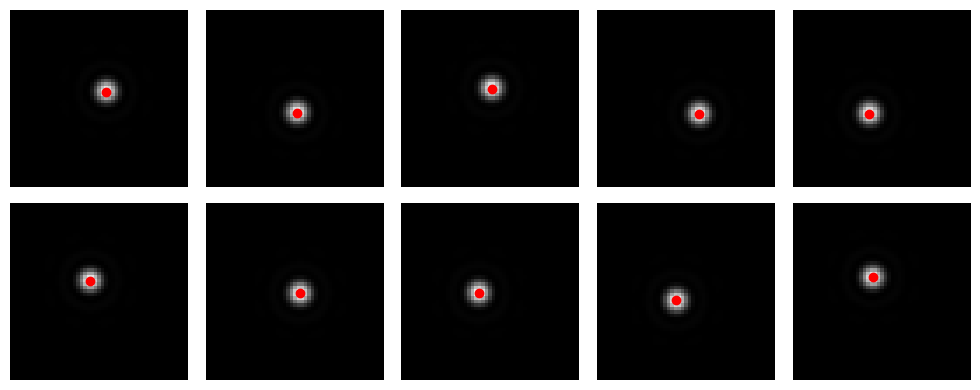

In [10]:
plt.figure(figsize=(10, 4))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(data[i, ..., 0], cmap="gray")
  plt.scatter(ground_truth[i, 1], ground_truth[i, 0], c="r")
  plt.axis("off")
  plt.tight_layout()
plt.show()

**Convolutional neural network**. This script defines a
convolutional neural network with a dense top that takes an image
as input and outputs the position of the object in the image.

In [11]:
model = dt.models.Convolutional(
input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
number_of_outputs=2,
)

In [12]:
import tensorflow.keras.backend as K

**Loss** **function**

In [13]:
def geometric_loss(transformation, prediction):
  de_transformed = prediction - transformation
  distance = K.std(de_transformed, axis=0)
  return distance
# transformation contains the translation applied to the images
# shape: (batch_size, 2)
# prediction contains the predicted position of the object in the images
# shape: (batch_size, 2)
model.compile(loss=geometric_loss, optimizer="adam")

In [14]:
def translation_function(translation):
  def translate_image(image):
    import scipy.ndimage as ndimage
    translated_image = ndimage.shift(
        image.squeeze(),
        translation,
        order=1,mode="reflect",
    )
    return translated_image[..., np.newaxis]
  return translate_image
translation_transformation = dt.Lambda(
    translation_function,
    translation=lambda:np.random.uniform(-5, 5, size=2),
)
def get_batch(data, batch_size=2):
  # data contains the anchor image
  # shape: (IMAGE_SIZE, IMAGE_SIZE, 1)
  output_data_buffer = np.zeros((batch_size, IMAGE_SIZE, IMAGE_SIZE, 1))
  output_label_buffer = np.zeros((batch_size, 2))
  for i in range(batch_size):
    translation_transformation.update()
    output_data_buffer[i] = translation_transformation(data)
    output_label_buffer[i] = translation_transformation.translation()
  return output_data_buffer, output_label_buffer

In [15]:
def train_epoch(images):
  # images contains the images to train on
  # shape: (N, IMAGE_SIZE, IMAGE_SIZE, 1)
  epoch_loss = 0
  for idx, anchor_image in enumerate(images):
    batch = get_batch(anchor_image)
    epoch_loss += model.train_on_batch(batch[0], batch[1])
  return epoch_loss / len(images)

In [16]:
training_data_size = 100
for epoch in range(20):
  print("Epoch: ", epoch)
  loss = train_epoch(data[:training_data_size])
  print("\nLoss: ", loss)

Epoch:  0

Loss:  0.8765872459113598
Epoch:  1

Loss:  0.23236812114715577
Epoch:  2

Loss:  0.21425724238157273
Epoch:  3

Loss:  0.23184467740356923
Epoch:  4

Loss:  0.19252055382356048
Epoch:  5

Loss:  0.18277889788150786
Epoch:  6

Loss:  0.18725466907024382
Epoch:  7

Loss:  0.1761141599342227
Epoch:  8

Loss:  0.16870534002780915
Epoch:  9

Loss:  0.22833801805973053
Epoch:  10

Loss:  0.16904338520020246
Epoch:  11

Loss:  0.15843859404325486
Epoch:  12

Loss:  0.1609032991528511
Epoch:  13

Loss:  0.13336480602622033
Epoch:  14

Loss:  0.1618994139879942
Epoch:  15

Loss:  0.13614291012287139
Epoch:  16

Loss:  0.14198196113109587
Epoch:  17

Loss:  0.15344578742980958
Epoch:  18

Loss:  0.12909659430384635
Epoch:  19

Loss:  0.14528310060501098


29/29 [==============================] - 1s 30ms/step


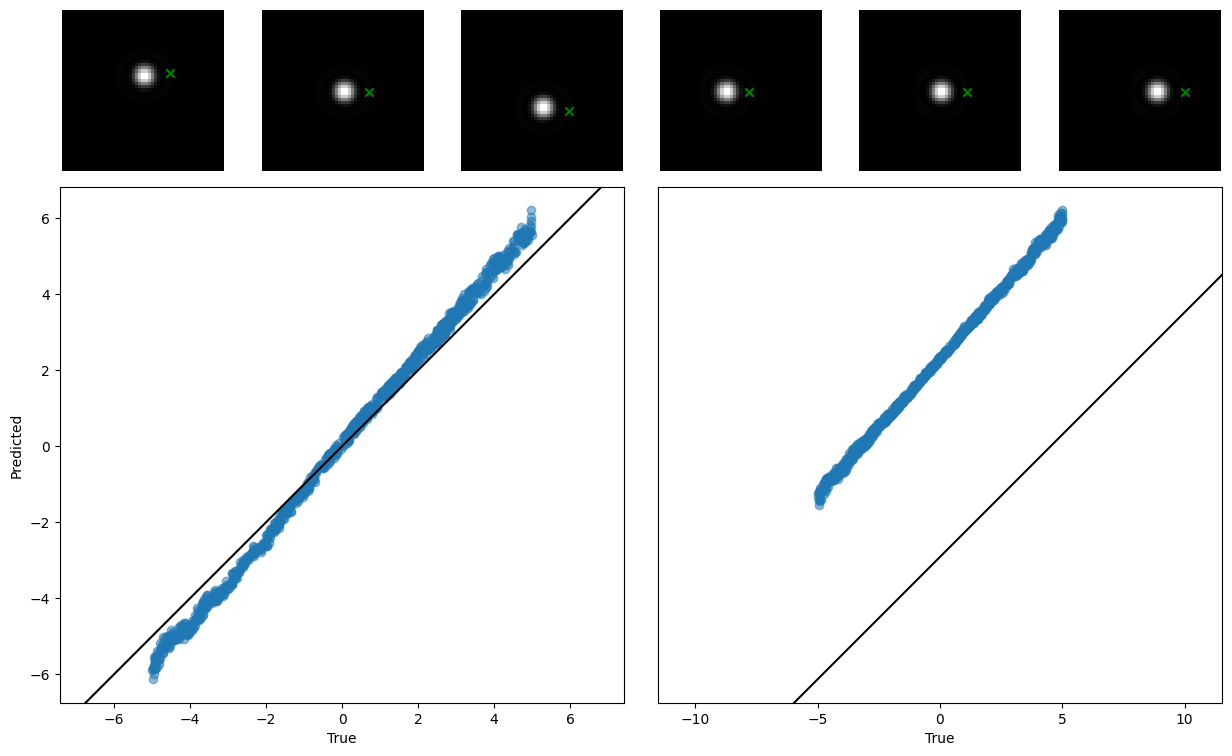

In [17]:
predictions = model.predict(data[training_data_size:])
gt = ground_truth[training_data_size:] - IMAGE_SIZE / 2
plt.figure(figsize=(15, 9))
grid = plt.GridSpec(4, 6, wspace=0.2, hspace=0.1)

plt.subplot(grid[1:, : 3])
plt.scatter(
    gt[:, 0],
    predictions[:, 0],
    alpha=0.5,
)
plt.axline((-5, -5), (5, 5), color="black")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.axis("equal")

plt.subplot(grid[1:, 3:])
plt.scatter(
    gt[:, 1],
    predictions[:, 1],
    alpha=0.5,
)
plt.axline((-5, -5), (5, 5), color="black")
plt.xlabel("True")
plt.axis("equal")
plt.yticks([])

for idx, offset in enumerate(np.linspace(-5, 5, 3)):
  # Create new data at specific offsets
  image_offset_x = data_simulation(position=(IMAGE_SIZE / 2 + offset,
                                             IMAGE_SIZE / 2))
  image_offset_y = data_simulation(position=(IMAGE_SIZE / 2, IMAGE_SIZE /
                                             2 + offset))
  predicted_positions = model.predict_on_batch(np.array([image_offset_x,
                                                         image_offset_y]))
  plt.subplot(grid[0, idx])
  plt.imshow(image_offset_x, cmap="gray")
  plt.scatter(
      IMAGE_SIZE / 2 + predicted_positions[0, 1],
      IMAGE_SIZE / 2 + predicted_positions[0, 0],
      color="g",
      marker="x"
  )
  plt.axis("off")
  plt.subplot(grid[0, 3 + idx])
  plt.imshow(image_offset_y, cmap="gray")
  plt.scatter(
    IMAGE_SIZE / 2 + predicted_positions[1, 1],
    IMAGE_SIZE / 2 + predicted_positions[1, 0],
    color="g",
    marker="x"
  )
  plt.axis("off")

plt.show()


### **LODESTAR**
-LodeSTAR uses a convolutional neural network without any fully
connected layers. Instead, it pools the output of the convolutional
layers to obtain a feature vector using a center-of-mass pooling
layer.


Creating a LodeSTAR network


In [18]:
model = dt.models.LodeSTAR(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
)

model.compile(
    optimizer="adam",
    loss="mae"
)

Creating a pipeline for LodeSTAR




In [19]:
training_data_size = 100
random_image = dt.Value(
    image_index= lambda: np.random.randint(0, training_data_size),
    value=lambda image_index: data[image_index]
)

Training LodeSTAR

In [20]:
model.fit(
    random_image,
    epochs=100,
    batch_size=8,
    steps_per_epoch=100,
)

Generating 160 / 160 samples before starting training
Epoch 1/100
100/100 [==============================] - 78s 657ms/step - total_loss: 2.0082 - consistency_loss: 1.1808
Epoch 2/100
100/100 [==============================] - 70s 705ms/step - total_loss: 0.1292 - consistency_loss: 0.0242
Epoch 3/100
100/100 [==============================] - 46s 458ms/step - total_loss: 0.0754 - consistency_loss: 0.0090
Epoch 4/100
100/100 [==============================] - 40s 398ms/step - total_loss: 0.0762 - consistency_loss: 0.0074
Epoch 5/100
100/100 [==============================] - 69s 691ms/step - total_loss: 0.0696 - consistency_loss: 0.0069
Epoch 6/100
100/100 [==============================] - 58s 578ms/step - total_loss: 0.0627 - consistency_loss: 0.0081
Epoch 7/100
100/100 [==============================] - 72s 724ms/step - total_loss: 0.0415 - consistency_loss: 0.0052
Epoch 8/100
100/100 [==============================] - 61s 606ms/step - total_loss: 0.0408 - consistency_loss: 0.0048
Ep

<font color="red">Questions </font>:
Why do I have 160 samples? batch_size refers to what?
total loss? consistency loss?

Evaluation Model

In [21]:
predictions = model.predict_and_pool(data[training_data_size:])-IMAGE_SIZE /2
gt = ground_truth[training_data_size:] - IMAGE_SIZE / 2

29/29 [==============================] - 9s 307ms/step


1/1 [==============================] - 0s 64ms/step


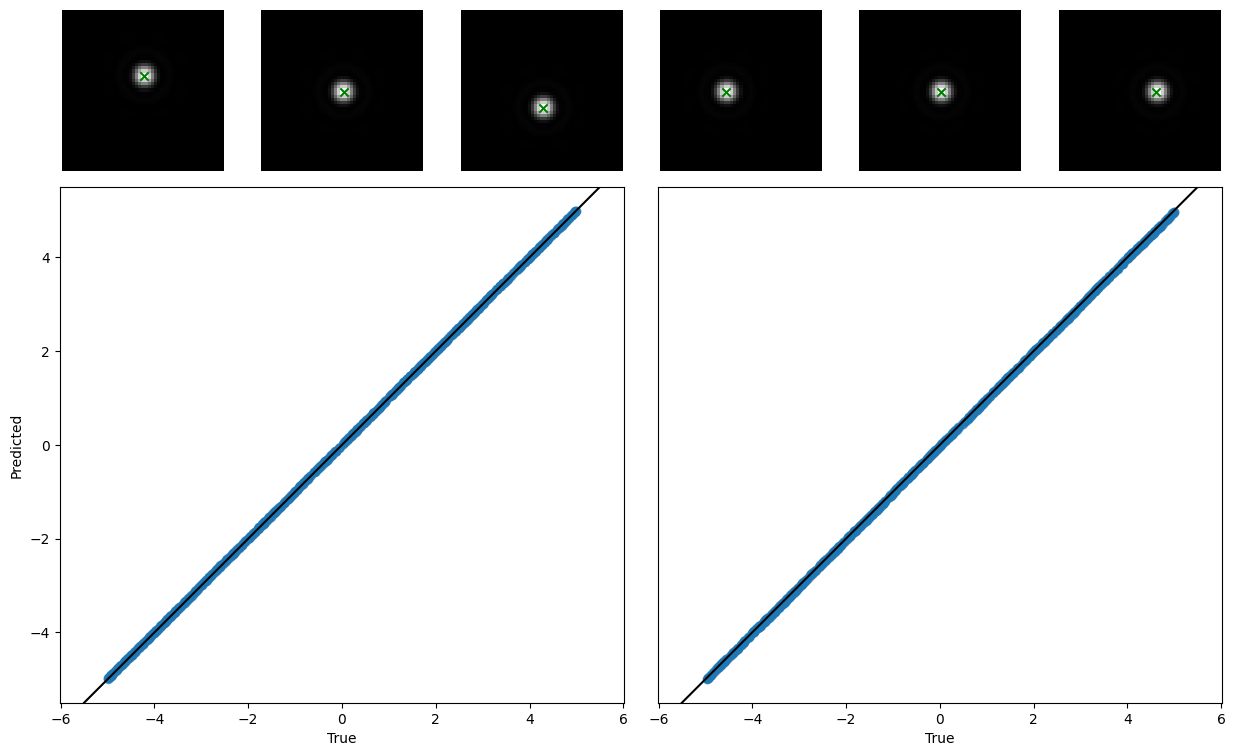

29/29 [==============================] - 8s 261ms/step


<ipython-input-34-442ad99a9909>:79: RuntimeWarning: Mean of empty slice.
  error_mean[i] = np.sqrt(error[digitized == i].mean())
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


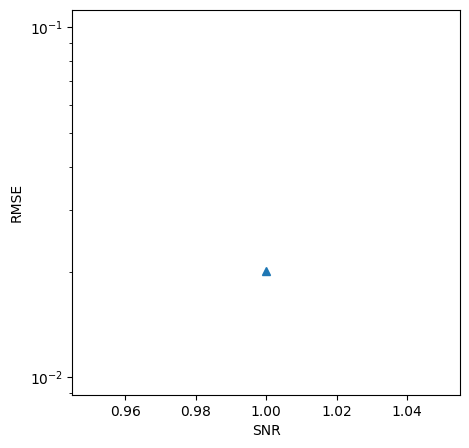

In [34]:
plt.figure(figsize=(15, 9))
rows = 4
cols = 6
grid = plt.GridSpec(rows, cols, wspace=0.2, hspace=0.1)
plt.subplot(grid[1:, : cols // 2])
plt.scatter(
    gt[:, 0],
  predictions[:, 0],
  alpha=0.5,
)
plt.axline((-5, -5), (5, 5), color="black")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.axis("equal")
# Plot the ground truth in grid 12

plt.subplot(grid[1:, cols//2:])
plt.scatter(
    gt[:, 1],
  predictions[:, 1],
  alpha=0.5,
)

plt.axline((-5, -5), (5, 5), color="black")
plt.xlabel("True")
plt.axis("equal")
plt.yticks([])
for idx, offset in enumerate(np.linspace(-5, 5, cols // 2)):
  data_simulation.update()
  image_offset_x = data_simulation(
      position=(IMAGE_SIZE / 2 + offset, IMAGE_SIZE / 2),
      signal_to_noise=10,
  )
  image_offset_y = data_simulation(
      position=(IMAGE_SIZE / 2, IMAGE_SIZE / 2 + offset),
      signal_to_noise=10,
  )
  predicted_positions = model.predict_and_pool(
       np.array([image_offset_x, image_offset_y])
  )

  plt.subplot(grid[0, idx])
  plt.imshow(image_offset_x, cmap="gray")
  plt.scatter(
      predicted_positions[0, 1],
      predicted_positions[0, 0],
      color="g",
      marker="x"
  )
  plt.axis("off")
  plt.subplot(grid[0, idx + cols // 2])
  plt.imshow(image_offset_y, cmap="gray")
  plt.scatter(
      predicted_positions[1, 1],
      predicted_positions[1, 0],
      color="g",
      marker="x"
  )
  plt.axis("off")
plt.show()
# Performance as a function of SNR
validation_prediction = model.predict_and_pool(data[training_data_size:])
validation_gt = ground_truth[training_data_size:]
noise = dt.Gaussian(
    sigma=lambda signal_to_noise: 1 / signal_to_noise,
    signal_to_noise = lambda: np.random.uniform(1, 100)
)
signal_to_noise = np.zeros((1000,))

validation_snr = signal_to_noise[training_data_size:]

error = (validation_prediction - validation_gt) ** 2

snr_bin_center = np.linspace(1, 100, 10)
digitized = np.digitize(validation_snr, snr_bin_center)

error_mean = np.zeros_like(snr_bin_center)
for i in range(10):
  error_mean[i] = np.sqrt(error[digitized == i].mean())
plt.figure(figsize=(5, 5))
plt.plot(snr_bin_center, error_mean, '^-')
plt.xlabel('SNR')
plt.ylabel('RMSE')
plt.yscale('log')
plt.show()




Exercise 6.2: Varying the training set size. We have seen that LodeSTAR outperforms the previous
neural network significantly for all signal-to-noise ratios. Try decreasing the size of the training set,
and see how the performance of LodeSTAR changes.


In [22]:
#training_data_size = 50
#random_image = dt.Value(
    #image_index= lambda: np.random.randint(0, training_data_size),
    #value=lambda image_index: data[image_index]
#)

Exercise 6.3: Varying noise level of the training data. An important consideration is how the perfor-
mance of LodeSTAR changes when it is evaluated on data with a different noise level than the training data. Plot the RMSE as a function of the signal-to-noise ratio for three different LodeSTAR networks trained on data with signal-to-noise ratios of 2, 10, and 50. What do you observe?


## Application 6A: **Multiparticle** Detection with LodeSTAR
- use LodeSTAR to detect multiple objects in an image without any
labeled data or any additional training. 

In [39]:
import os 
os.getcwd() 


'/content'

In [ ]:
# import zipfile
# with zipfile.ZipFile(pathtozipfile, 'r') as zip_ref:
#   zip_ref.extractall(directory_to_extract_to)

In [49]:

import glob
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive')


dataset_path = "BF-C2DL-HSC" 
image_02_paths = glob.glob(
    os.path.join(dataset_path, "02", "*.tif")
)

label_02_paths = glob.glob(
    os.path.join(dataset_path, "02_GT", "TRA", "*.tif")
)

image_02_paths = sorted(image_02_paths) 
label_02_paths = sorted(label_02_paths)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
!pip install imagecodecs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


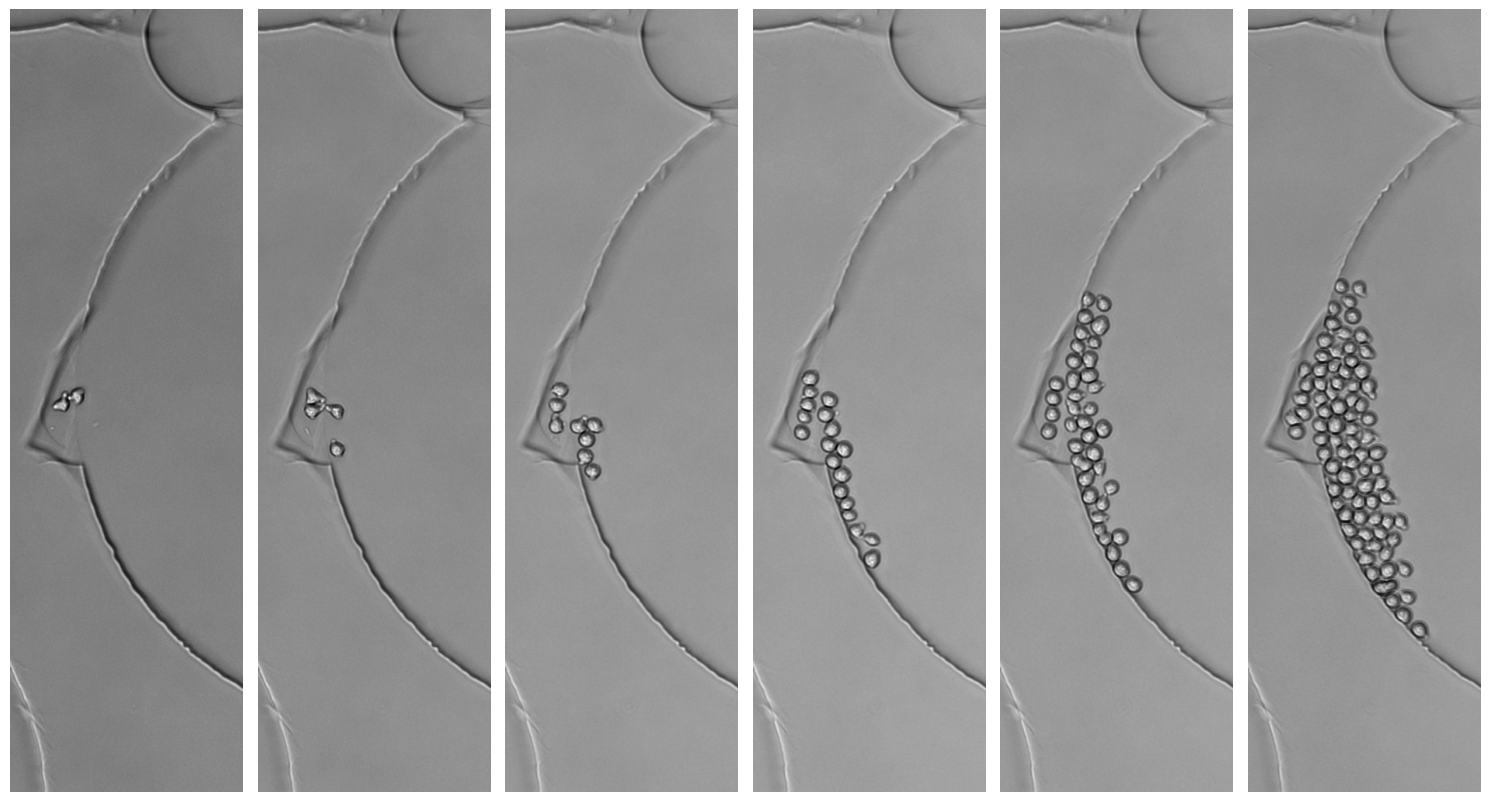

In [57]:
import matplotlib.pyplot as plt
import skimage
import skimage.io
import imagecodecs


plt.figure(figsize=(15, 10))

for plt_index, data_index in enumerate([0, 300, 600, 900, 1200, 1500]):
  image = imagecodecs.imread(image_02_paths[data_index])
  cropped_image = image[:, :300] 
  plt.subplot(1, 6, plt_index + 1)
  plt.imshow(cropped_image, cmap="gray")
  plt.axis("off")

plt.tight_layout()
plt.show()

SEG/TRA segmentation masks

###Loading and displaying the crop that we will use for training

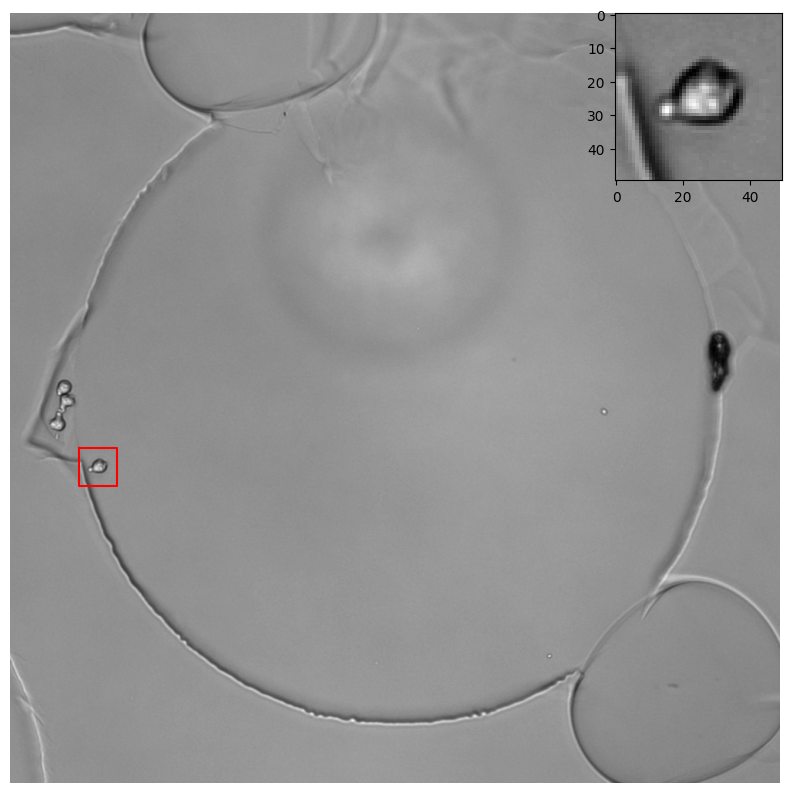

In [60]:
import numpy as np

frame = 282
width = 50
x = 595 - width // 2
y = 115 - width // 2

image = imagecodecs.imread(image_02_paths[frame])
crop = image[x:x+width, y:y+width]

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(111)
plt.imshow(image, cmap="gray")
plt.plot([y, y+width, y+width, y, y], [x, x, x+width, x+width, x], "r-")
plt.axis("off")
fig.add_subplot(444)
plt.imshow(crop, cmap="gray")

plt.savefig("fig_20_02.png", dpi=300)
plt.show()

###Create a DeepTrack2 pipeline that will feed the crop to the neural network

We will augment the training
data by randomly multiplying and
adding a small amount to the image.
Feel free to experiment with different
augmentations, even distoring the
image slightly.

In [67]:
import deeptrack as dt



normalization = dt.Divide(255)
value = dt.Value(crop)
augmentations = (
    dt.Multiply(lambda: np.random.uniform(0.95, 1.05))
  >> dt.Add(lambda: np.random.uniform(-0.05, 0.05))
)

training_pipeline = value >> normalization >> augmentations

###Define and train the LodeSTAR neural network

In [ ]:
model = dt.models.LodeSTAR()

model.fit(
    training_pipeline,
    epochs=50,
    batch_size=8,
    steps_per_epoch=100,
)

Generating 166 / 160 samples before starting training
Epoch 1/50
100/100 [==============================] - 60s 508ms/step - total_loss: 3.4671 - consistency_loss: 1.9269
Epoch 2/50
100/100 [==============================] - 57s 574ms/step - total_loss: 3.1024 - consistency_loss: 1.7448
Epoch 3/50
100/100 [==============================] - 74s 745ms/step - total_loss: 3.4407 - consistency_loss: 1.9121
Epoch 4/50
100/100 [==============================] - 69s 684ms/step - total_loss: 2.6269 - consistency_loss: 1.4911
Epoch 5/50
100/100 [==============================] - 57s 564ms/step - total_loss: 3.5196 - consistency_loss: 1.7852
Epoch 6/50
100/100 [==============================] - 72s 721ms/step - total_loss: 1.8752 - consistency_loss: 1.0653
Epoch 7/50
100/100 [==============================] - 70s 702ms/step - total_loss: 0.4687 - consistency_loss: 0.2569
Epoch 8/50
100/100 [==============================] - 62s 618ms/step - total_loss: 0.1247 - consistency_loss: 0.0341
Epoch 9/50

###Evaluating the neural network

In [ ]:
validation_data_stride = 10

validation_data_paths = image_02_paths[::validation_data_stride]
validation_labels_paths = label_02_paths[::validation_data_stride]
validation_images = np.array([
  normalization(skimage.io.imread(path)) for path in
   validation_data_paths
])
validation_labels = [skimage.io.imread(path) for path in
     validation_labels_paths]

validation_images = validation_images[:, :, :300]

###Converting the masks to lists of positions of the cells

In [ ]:
def label_mask_to_position(label):
  label = skimage.measure.regionprops(label)
  centroids = [prop.centroid for prop in label]
  return np.array(centroids)

validation_positions = [label_mask_to_position(label) for label in
     validation_labels]

###Detecting the cells in the images

In [ ]:
position_feature, mass_feature = model.predict(validation_images,
     batch_size=4)


###Plotting the outputs of the neural network

image, mass channel, position channel

The mass channel can be segmented to find the cells. The position channel, where clustered positions can be used to find
the cell.

In [ ]:
plt.figure(figsize=(10, 10))

image_index = 150
plt.subplot(1, 3, 1)
plt.imshow(validation_images[image_index], cmap="gray")
plt.axis("off")
plt.text(10, 30, "a", fontsize=20, fontweight="bold", color="white")

plt.subplot(1, 3, 2)
plt.imshow(mass_feature[image_index], cmap="gray")
plt.axis("off")
plt.text(5, 15, "b", fontsize=20, fontweight="bold", color="white")

plt.subplot(1, 3, 3)
plt.scatter(
    position_feature[image_index, :, :, 1].flatten(), 
    position_feature[image_index, :, :, 0].flatten(),
    alpha=0.1,
    s=5,
)
plt.xlim(0, 300)
plt.ylim(0, 1010)
plt.gca().invert_yaxis()
plt.text(10, 30, "c", fontsize=20, fontweight="bold", color="black")

plt.tight_layout()
plt.show()


###Detecting cells in the images
The parameters a and b
are used to weight the metrics based
on the mass channel and the position
channel, respectively. As a rule of
thumb, b should be high if the objects
are very similar, and a should be
high if the objects are very different. Moreover, a + b = 1.
The parameter mode is used to
determine how the threshold should
be calculated. As a rule of thumb, use
mode = constant if the number of
objects changes significantly between
images, and use mode = quantile
if the number of objects is roughly
constant between images.

In [ ]:
detected_positions = model.predict_and_detect(
    validation_images,
    alpha=0.1,
    beta=0.9,
    mode="constant",
    cutoff=0.2,
)

### Visualizing the detected cells in the images
If you see that the model misses some cells, you can decrease
the cutoff parameter. If you see that the model detects too many
cells, you can increase the cutoff parameter.

In [ ]:
plt.figure(figsize=(15, 10)

for plot_idx, frame_idx in enumerate([0, 30, 60, 90, 120, 150]):
  predicted_positions = detected_positions[frame_idx]
  plt.subplot(1, 6, plot_idx + 1)
  plt.imshow(validation_images[frame_idx], cmap="gray")
  plt.scatter(
      predicted_positions[:, 1],
      predicted_positions[:, 0],
      s=10,
      c="b",
  )
  plt.axis("off")
plt.tight_layout()
plt.show()

###Quantitatively evaluate the model by measuring the F1 score

In [ ]:
import scipy
distance_th = 10

TP = 0
FP = 0
FN = 0

for predicted_positions, true_positions in zip(detected_positions,
     validation_positions):
  distance_matrix = scipy.spatial.distance_matrix(predicted_positions,
     true_positions)
  row_ind, col_ind = scipy.optimize.linear_sum_assignment(distance_matrix)

  filtered_row_ind = row_ind[distance_matrix[row_ind, col_ind] <
     distance_th] 
  filtered_col_ind = col_ind[distance_matrix[row_ind, col_ind] <
distance_th] 

  TP += len(filtered_row_ind)
  FP += len(predicted_positions) - len(filtered_row_ind)
  FN += len(true_positions) - len(filtered_col_ind)
f1 = 2 * TP / (2 * TP + FP + FN)
print(
    f"""
TP: {TP}
FP: {FP}
FN: {FN}
F1: {f1}"""
)

Exercise 6.4: Crop size. We arbitrarily chose the size of the training crop to be 50 ⇥ 50 pixels. What happens if we choose a larger or smaller size? Try training at 30⇥30 pixels and 70⇥70 pixels. Does it improve the results?


Exercise 6.5: Alternative and multiple training images. Try training the model on a different crop.
Find an isolated cell in the images, and crop the image around the cell. Does it improve the results?
Bonus: Try training the model on multiple crops.


Exercise 6.6: Sequence 01. Evaluate the model on the 01 sequence. Does the model perform as expected?

In [ ]:

dataset_path = "BF-C2DL-HSC"

image_02_paths = glob.glob(os.path.join(dataset_path, "02", "*.tif"))
label_02_paths = glob.glob(os.path.join(dataset_path, "02_GT", "TRA", "*.tif"))
image_02_paths = sorted(image_02_paths)
label_02_paths = sorted(label_02_paths)

frame = 282
width = 50
x = 595 - width // 2
y = 115 - width // 2
image = imagecodecs.imread(image_02_paths[frame])
crop = image[x : x + width, y : y + width]
normalization = dt.Divide(255)
training_pipeline = (
    dt.Value(crop)
    >> normalization
    >> dt.Multiply(lambda: np.random.uniform(0.95, 1.05))
    >> dt.Add(lambda: np.random.uniform(-0.05, 0.05))

model = dt.models.LodeSTAR()
model.fit(
    training_pipeline,
    epochs=50,
    batch_size=8,
    steps_per_epoch=100,
)

def label_mask_to_position(label):
  label = skimage.measure.regionprops(label)
  centroids = [prop.centroid for prop in label]
  return np.array(centroids)

validation_data_stride = 10
validation_data_paths = image_02_paths[::validation_data_stride]
validation_labels_paths = label_02_paths[::validation_data_stride]
validation_images = np.array(
    [normalization(skimage.io.imread(path)) for path in validation_data_paths]
)
validation_labels = [skimage.io.imread(path) for path in validation_labels_paths]
validation_images = validation_images[:, :, :300]
validation_positions = [label_mask_to_position(label) for label in validation_labels]


In [ ]:
detected_positions = model.predict_and_detect(
    validation_images,
    alpha=0.1,
    beta=0.9,
    mode="constant",
    cutoff=0.2,
)
import scipy
distance_th = 10
TP = 0
FP = 0
FN = 0
for predicted_positions, true_positions in zip(
    detected_positions, validation_positions
  ):
    distance_matrix = scipy.spatial.distance_matrix(predicted_positions, true_positions)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(distance_matrix)
    filtered_row_ind = row_ind[distance_matrix[row_ind, col_ind] < distance_th]
    filtered_col_ind = col_ind[distance_matrix[row_ind, col_ind] < distance_th]
    TP += len(filtered_row_ind)
    FP += len(predicted_positions) - len(filtered_row_ind)
    FN += len(true_positions) - len(filtered_col_ind)
f1 = 2 * TP / (2 * TP + FP + FN)
print(
    TP: {TP}
    FP: {FP}
    FN: {FN}
    F1: {f1}""
)